<a href="https://colab.research.google.com/github/RajAakash/torch/blob/main/ClassificationTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

In [18]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [20]:
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [21]:
from sklearn.datasets import make_circles


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [22]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [23]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [26]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


In [28]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

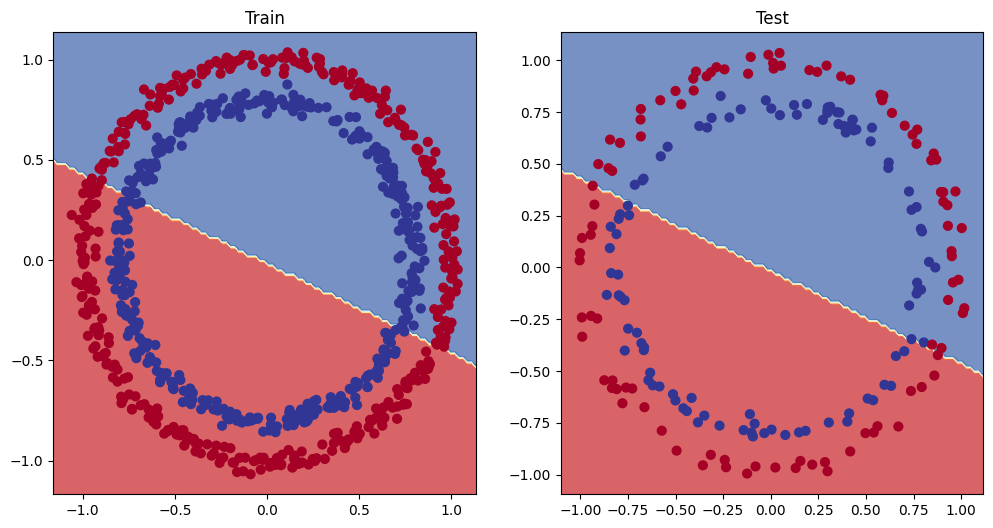

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)